<a href="https://colab.research.google.com/github/Anirudh-R-1201/Shot_xG/blob/main/ExpectedGoals_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from collections import OrderedDict
from imblearn.under_sampling import TomekLinks

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import files
files.upload()

Saving shots.csv to shots.csv
Saving data.csv to data.csv
Saving non_pen.csv to non_pen.csv
Saving pens.csv to pens.csv


{'shots.csv': b'duration,pass_aerial_won,pass_angle,pass_body_part_name,pass_cross,pass_cut_back,pass_deflected,pass_height_name,pass_length,pass_switch,pass_through_ball,play_pattern_name,shot_aerial_won,shot_body_part_name,shot_first_time,shot_one_on_one,shot_open_goal,shot_technique_name,under_pressure,goal,distance,angle,build_up_duration,direct_free_kick,shot_cone,num_players_in_shot_cone,distance_to_nearest_opponent,pass_angle_na,pass_length_na,distance_to_nearest_opponent_na\n1.301567,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,foot,0,0,0,Normal,0,0,28.66810073932349,0.4745676117403513,19.779433,1,102.0,0,16.890825912311097,True,True,False\n0.054247,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,foot,1,0,0,Normal,0,0,21.019038988498018,0.4636476090008061,1.717753,1,75.19999999999982,0,10.43934863868431,True,True,False\n0.160234,0,0.0,,0,0,0,,0.0,0,0,From Free Kick,0,foot,0,0,0,Normal,1,0,16.807736313971606,0.24642166356830222,5.599766,1,65.19999999999982,0,3.3955853692699254,True,True,False\

In [ ]:
data = pd.read_csv('shots.csv', index_col=0)
X = data.drop(['pass_height_name','pass_body_part_name','pass_angle_na', 'shot_body_part_name', 'pass_length_na','shot_technique_name','play_pattern_name'  ,'distance_to_nearest_opponent_na' ,'goal'], axis=1)
y = data['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y, random_state=42)
data=data.drop(['pass_height_name','pass_angle_na',  'pass_length_na','shot_technique_name','play_pattern_name'  ,'distance_to_nearest_opponent_na' ], axis=1)
X.dtypes

pass_aerial_won                   int64
pass_angle                      float64
pass_cross                        int64
pass_cut_back                     int64
pass_deflected                    int64
pass_length                     float64
pass_switch                       int64
pass_through_ball                 int64
shot_aerial_won                   int64
shot_first_time                   int64
shot_one_on_one                   int64
shot_open_goal                    int64
under_pressure                    int64
distance                        float64
angle                           float64
build_up_duration               float64
direct_free_kick                  int64
shot_cone                       float64
num_players_in_shot_cone          int64
distance_to_nearest_opponent    float64
dtype: object

In [ ]:
def plot_loss(model_list, min_estimators=10, max_estimators=200):
    loss_rate = OrderedDict((clf_name, []) for clf_name, _ in model_list)
    least_loss = 100
    least_loss_loc = 0
    min_estimators = min_estimators
    max_estimators = max_estimators

    for clf_name, clf in model_list:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
            brier = brier_score_loss(y_test, y_pred_proba[:,1])
            loss_rate[clf_name].append((i, brier))
            if brier < least_loss:
              least_loss = brier
              least_loss_loc = i


    plt.figure(figsize=(12,8))

    for clf_name, clf_err in loss_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=clf_name)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("Brier loss")
    plt.legend(loc="upper right");
    print("Brier loss least - " + str(least_loss))
    print("at - " + str(least_loss_loc))
    print(str(clf_name))
    return

In [ ]:
max_features = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features='sqrt', random_state=42)),
    ("RandomForestClassifier, max_features=0.5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=0.5, random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, random_state=42)),
]

plot_loss(max_features)

Brier loss least - 0.08267830993194936
at - 104
RandomForestClassifier, max_features=None


In [ ]:
min_leaf = [
    ("RandomForestClassifier, min_samples_leaf=1",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=1, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=3, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=5, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=10",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=10, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=25",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=25, random_state=42)),
]

plot_loss(min_leaf)

Brier loss least - 0.08005957475636144
at - 185
RandomForestClassifier, min_samples_leaf=25


In [ ]:
min_leaf = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
train_results = []
test_results = []
for leaf in min_leaf:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(min_leaf, train_results, 'b', label='Train loss')
line2, = plt.plot(min_leaf, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('min_samples_leaf');

Brier loss least - 0.07989985100109512
at - 169
RandomForestClassifier, max_depth=None


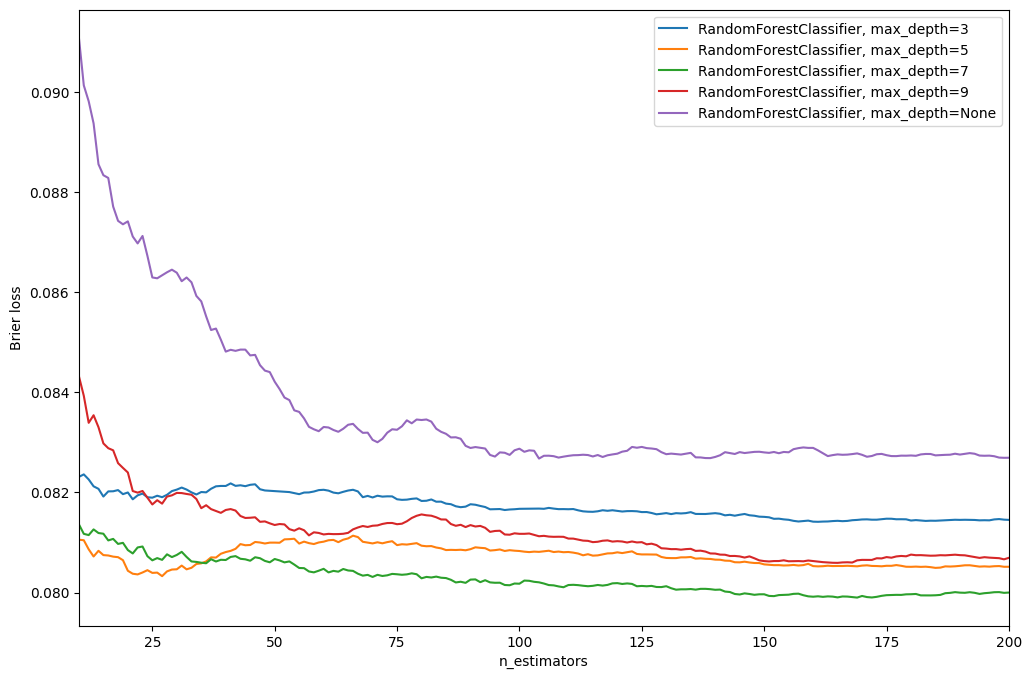

In [ ]:
max_depth = [
    ("RandomForestClassifier, max_depth=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=3, random_state=42)),
    ("RandomForestClassifier, max_depth=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=5, random_state=42)),
    ("RandomForestClassifier, max_depth=7",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=7, random_state=42)),
    ("RandomForestClassifier, max_depth=9",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=9, random_state=42)),
    ("RandomForestClassifier, max_depth=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=None, random_state=42)),
]

plot_loss(max_depth)

In [ ]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=int(max_depth), n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(max_depths, train_results, 'b', label='Train loss')
line2, = plt.plot(max_depths, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('max_depth');

In [ ]:
import sklearn
from sklearn.metrics import brier_score_loss
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
m = RandomForestClassifier(n_estimators=55, n_jobs=-1, max_features='sqrt', random_state=42)
#m = RandomForestClassifier(n_estimators=100,max_depth= 5, max_features= 'sqrt', min_samples_leaf= 12, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="accuracy")
print('accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))

from imblearn.over_sampling import RandomOverSampler
print("Over Sampling")
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="accuracy")
print('accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))


from imblearn.under_sampling import ClusterCentroids
print("under sampling")
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="accuracy")
print('accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(m, X_resampled, y_resampled, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))

accuracy : 0.90161
recall : 0.08679
precision: 0.45330
f1 : 0.14452
roc_auc : 0.71668
balanced_accuracy : 0.53782
Over Sampling
accuracy : 0.96400
recall : 0.99123
precision: 0.94004
f1 : 0.96496
roc_auc : 0.99677
balanced_accuracy : 0.96400
under sampling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


accuracy : 0.87066
recall : 0.84375
precision: 0.89184
f1 : 0.86709
roc_auc : 0.93562
balanced_accuracy : 0.87066


In [ ]:
params = {
    'min_samples_leaf': [i for i in range(1,25)],
    'max_depth': [i for i in range(1,10)],
    'max_features': ["sqrt", 0.5]
}

gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
                  scoring='accuracy', return_train_score=True)

gs.fit(X_train, y_train)

def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_),'using %s' % gs.best_params_)
    return
print("Standard")
print_gs_results(gs=gs, print_all=False)
print("\n\nOver Sampling")
gs.fit(X_resampled, y_resampled)
print_gs_results(gs=gs, print_all=False)

Standard
Best: 0.90713 using {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2}


Over Sampling
Best: 0.86979 using {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [ ]:
xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='accuracy')
print('accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))

print("Over Sampling")
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
xgb.fit(X_resampled, y_resampled)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print('Accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))

from imblearn.under_sampling import ClusterCentroids
print("Under sampling")
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)

xgb.fit(X_resampled, y_resampled)
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print('Accuracy :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="recall")
print('recall :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="precision")
print('precision:', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="f1")
print('f1 :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="roc_auc")
print('roc_auc :', "{0:.5f}".format(np.mean(scores)))
scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring="balanced_accuracy")
print('balanced_accuracy :', "{0:.5f}".format(np.mean(scores)))


accuracy : 0.89297
recall : 0.10666
precision: 0.33293
f1 : 0.16156
roc_auc : 0.69150
balanced_accuracy : 0.54190
Over Sampling
Accuracy : 0.94501
recall : 0.99044
precision: 0.90798
f1 : 0.94741
roc_auc : 0.98439
balanced_accuracy : 0.94501
Under sampling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy : 0.86979
recall : 0.83333
precision: 0.89916
f1 : 0.86469
roc_auc : 0.93409
balanced_accuracy : 0.86979


In [ ]:
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.4],
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=9)],
    'max_depth': [i for i in range(3, 10)],
    'min_child_weight': [i for i in range(1, 7)],
    'subsample': [i/10.0 for i in range(6,11)],
    'colsample_bytree': [i/10.0 for i in range(6,11)]
}
rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
                         scoring='accuracy', return_train_score=True)
print("Standard")
rgs.fit(X_train, y_train)

print_gs_results(gs=rgs, print_all=False)
print("\n\n\n\n")
print("Over Sampling")
rgs.fit(X_resampled, y_resampled)

print_gs_results(gs=rgs, print_all=False)

Standard
Best: 0.90545 using {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.001, 'colsample_bytree': 0.9}





Over Sampling
Best: 0.86632 using {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [ ]:

def print_results(rf, xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):


    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)


    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))

    print("Over sampling")
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    rf.fit(X_resampled, y_resampled)
    xgb.fit(X_resampled, y_resampled)
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]
    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))

    print("Under sampling")
    X_resampled, y_resampled = cc.fit_resample(X, y)
    rf.fit(X_resampled, y_resampled)
    xgb.fit(X_resampled, y_resampled)
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]
    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))


    return

best_rf = gs.best_estimator_
best_xgb = rgs.best_estimator_

print_results(rf=best_rf, xgb=best_xgb)

Actual goals: 173
Predicted goals (rf): 163.14
Predicted goals (xgb): 164.46
Brier loss (rf): 0.08102
Brier loss (xgb): 0.08002
Over sampling
Actual goals: 173
Predicted goals (rf): 632.22
Predicted goals (xgb): 633.26
Brier loss (rf): 0.15610
Brier loss (xgb): 0.15926
Under sampling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 1116.31
Predicted goals (xgb): 1176.67
Brier loss (rf): 0.41047
Brier loss (xgb): 0.46096


In [ ]:
calibrated_rf = CalibratedClassifierCV(gs.best_estimator_, cv=cv, method='sigmoid')
calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')

print_results(rf=calibrated_rf, xgb=calibrated_xgb)

Actual goals: 173
Predicted goals (rf): 165.06
Predicted goals (xgb): 161.04
Brier loss (rf): 0.08111
Brier loss (xgb): 0.08157
Over sampling
Actual goals: 173
Predicted goals (rf): 479.49
Predicted goals (xgb): 547.81
Brier loss (rf): 0.14111
Brier loss (xgb): 0.15450
Under sampling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 1208.37
Predicted goals (xgb): 1228.23
Brier loss (rf): 0.50424
Brier loss (xgb): 0.51834


In [ ]:
tomek = TomekLinks(n_jobs=-1)
X_train_res, y_train_res = tomek.fit_resample(X_train, y_train)

print('UNCALIBRATED')
print_results(rf=best_rf, xgb=best_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)
print('\nCALIBRATED')
print_results(rf=calibrated_rf, xgb=calibrated_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)

UNCALIBRATED


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 175.45
Predicted goals (xgb): 173.72
Brier loss (rf): 0.08053
Brier loss (xgb): 0.07994
Over sampling


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 621.46
Predicted goals (xgb): 635.57
Brier loss (rf): 0.15444
Brier loss (xgb): 0.16077
Under sampling


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 1116.31
Predicted goals (xgb): 1176.67
Brier loss (rf): 0.41047
Brier loss (xgb): 0.46096

CALIBRATED


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 174.22
Predicted goals (xgb): 171.37
Brier loss (rf): 0.08115
Brier loss (xgb): 0.08141
Over sampling


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Actual goals: 173
Predicted goals (rf): 484.79
Predicted goals (xgb): 558.84
Brier loss (rf): 0.14498
Brier loss (xgb): 0.15829
Under sampling
Actual goals: 173
Predicted goals (rf): 1208.37
Predicted goals (xgb): 1228.23
Brier loss (rf): 0.50424
Brier loss (xgb): 0.51834


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


calibrated RF model is the best

In [ ]:
import pickle
filename = 'final_model (2).sav'
#pickle.dump(calibrated_rf, open(filename, 'wb'))

#files.download('final_model.sav')
model = pickle.load(open(filename, 'rb'))

In [ ]:
non_pen = pd.read_csv('non_pen.csv', index_col=0)
pens = pd.read_csv('pens.csv', index_col=0)

X_new = non_pen.drop('goal', axis=1)
y_new = non_pen['goal']

extra_cols = ['player_name', 'team_name', 'match_id', 'x_loc', 'y_loc', 'pass_player_name']
extras = X_new[extra_cols]
X_new= X_new.drop(extra_cols, axis=1)

model.fit(X_new, y_new)

xg_df = X_new.copy()
xg_df['goal'] = y_new
xg_df['xg'] = model.predict_proba(X_new)[:,1]
xg_df['xa'] = np.where(xg_df['xg'].isna(), 0, xg_df['xg'])
xg_df = xg_df.merge(extras, left_index=True, right_index=True)
xg_df = xg_df.append(pens, sort=True)

xg_df['x_loc_m'] = xg_df['x_loc'] / 120 * 104
xg_df['y_loc_m'] = xg_df['y_loc'] / 80 * 68

<ipython-input-8-c64c667029aa>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xg_df = xg_df.append(pens, sort=True)


In [ ]:
# See http://petermckeever.com/plotting-xy-football-data-in-python/
def draw_pitch(pitch, line, orientation, view):

    orientation = orientation
    view = view
    line = line
    pitch = pitch

    if orientation.lower().startswith("h"):

        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(69,105)
            plt.ylim(-1,69)
            # final third line
            lxt = [0,68]
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16]
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16]
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68]
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(69,105)
            plt.xlim(-1,69)
            # final third line
            lxt = [0,68]
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16]
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16]
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68]
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        return

In [ ]:
xg_df['team_name'].unique()

array(['Barcelona', 'Espanyol', 'RC Deportivo La Coruña', 'Sevilla',
       'Mallorca', 'Málaga', 'Real Valladolid', 'Valencia', 'Osasuna',
       'Getafe', 'Atlético Madrid', 'Tenerife', 'Real Madrid',
       'Athletic Club', 'Sporting Gijón', 'Racing Santander',
       'Villarreal', 'Xerez', 'Almería', 'Real Zaragoza'], dtype=object)

In [ ]:
temp = xg_df[xg_df['team_name'] == 'Barcelona']
temp['player_name'].unique()

array(['Daniel Alves da Silva', 'Xavier Hernández Creus',
       'Lionel Andrés Messi Cuccittini', 'Rafael Márquez Álvarez',
       'Bojan Krkíc Pérez', 'Thierry Henry', 'Sergio Busquets i Burgos',
       'Pedro Eliezer Rodríguez Ledesma', 'Zlatan Ibrahimović',
       'Andrés Iniesta Luján', 'Carles Puyol i Saforcada',
       'Jeffren Isaac Suárez Bermúdez', 'Gnégnéri Yaya Touré',
       'Maxwell Scherrer Cabelino Andrade', 'Seydou Kéita',
       'Gerard Piqué Bernabéu', 'Dmytro Chygrynskiy',
       'Gabriel Alejandro Milito', 'Thiago Alcântara do Nascimento',
       'Jonathan dos Santos Ramírez', 'Eric-Sylvain Bilal Abidal'],
      dtype=object)

<ipython-input-9-0ef7ae2d67c7>:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(10.4,6.8))


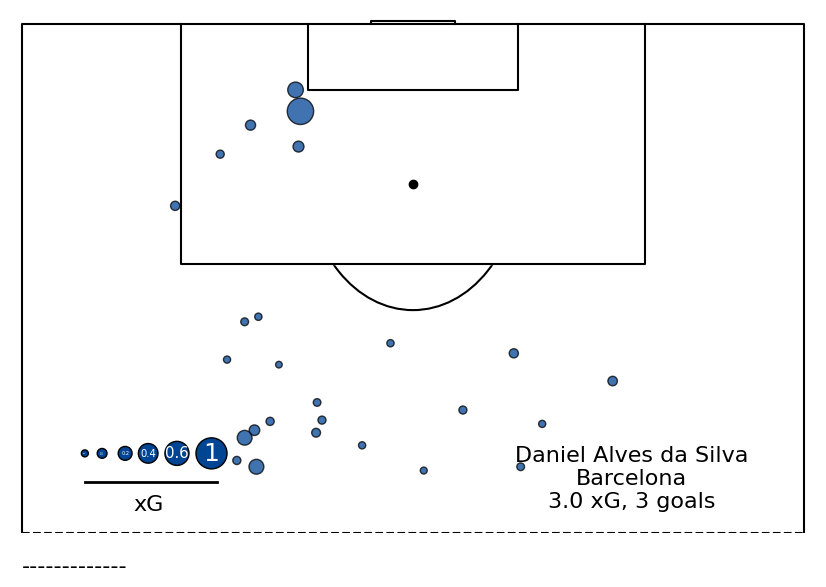

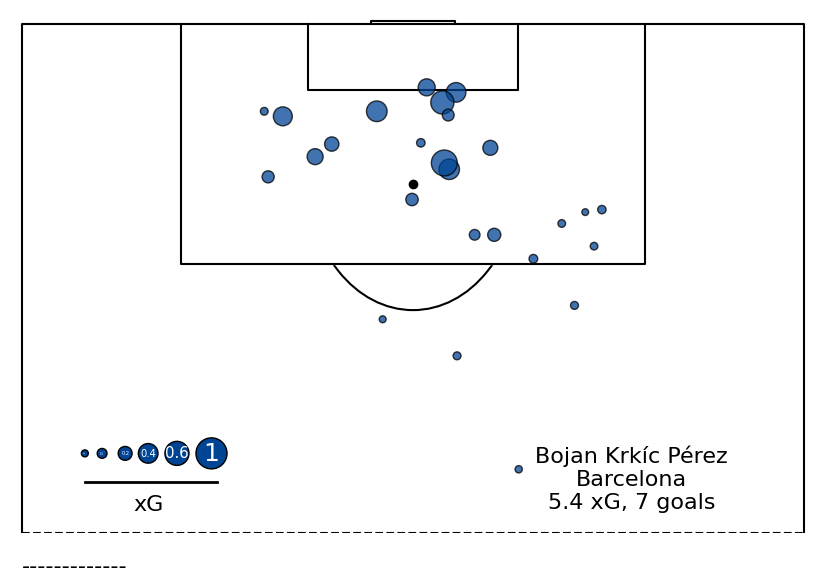

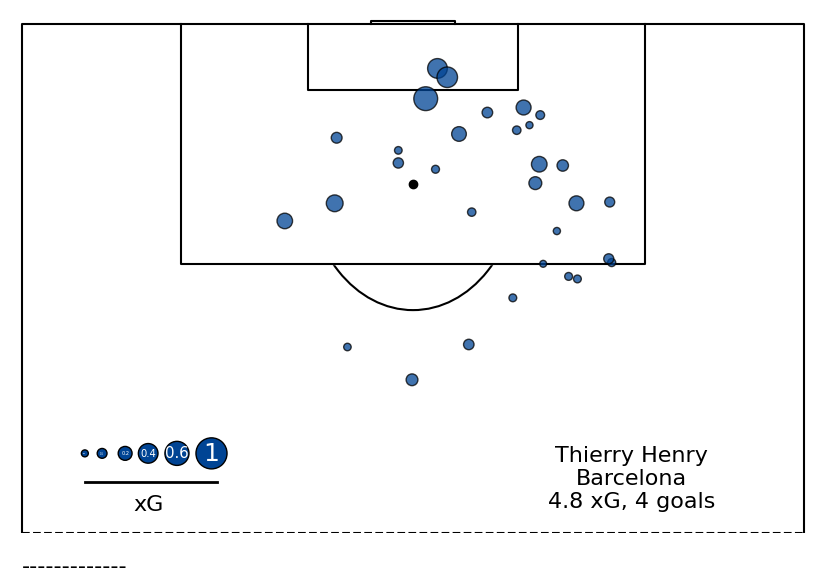

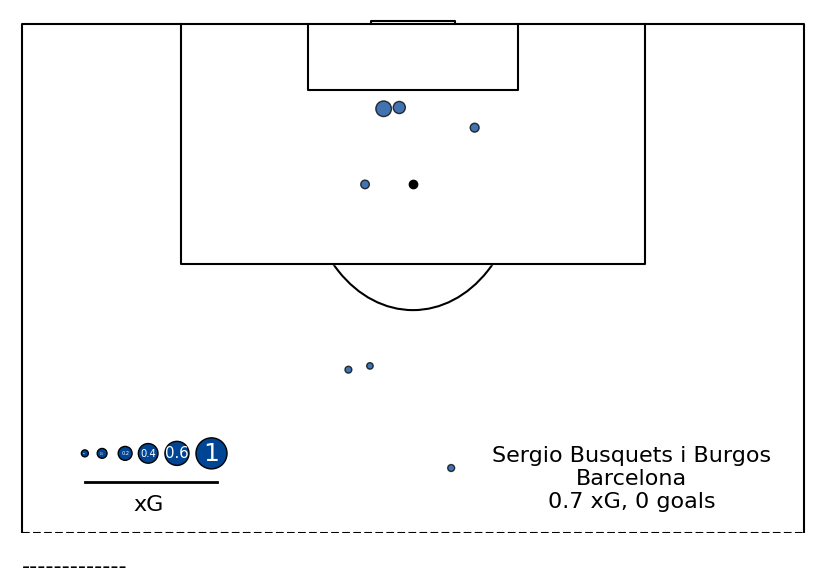

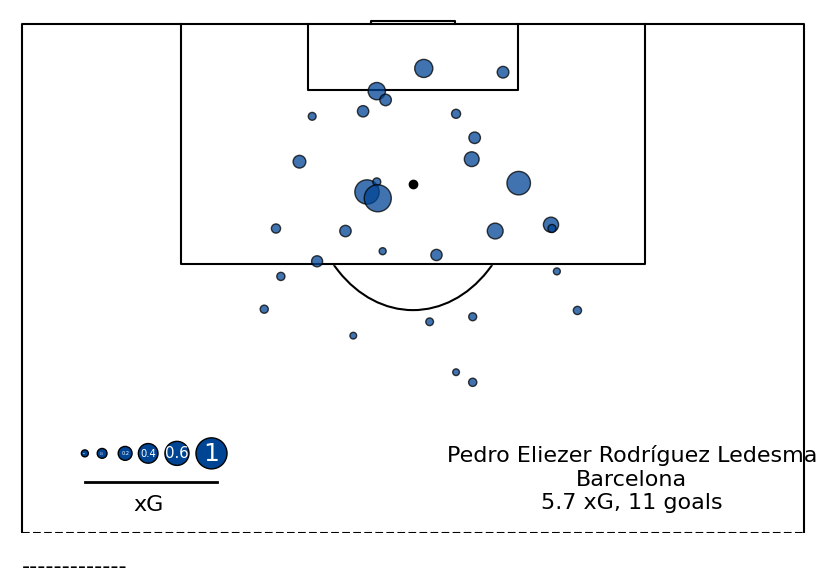

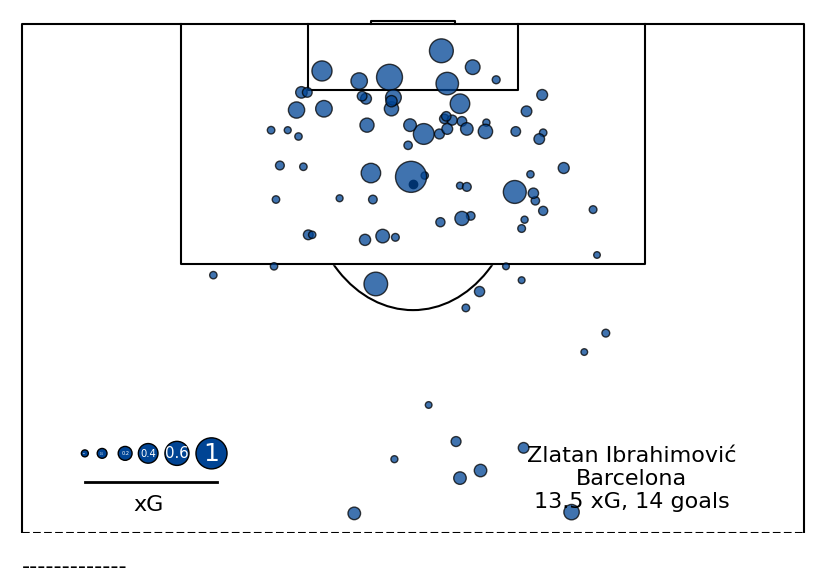

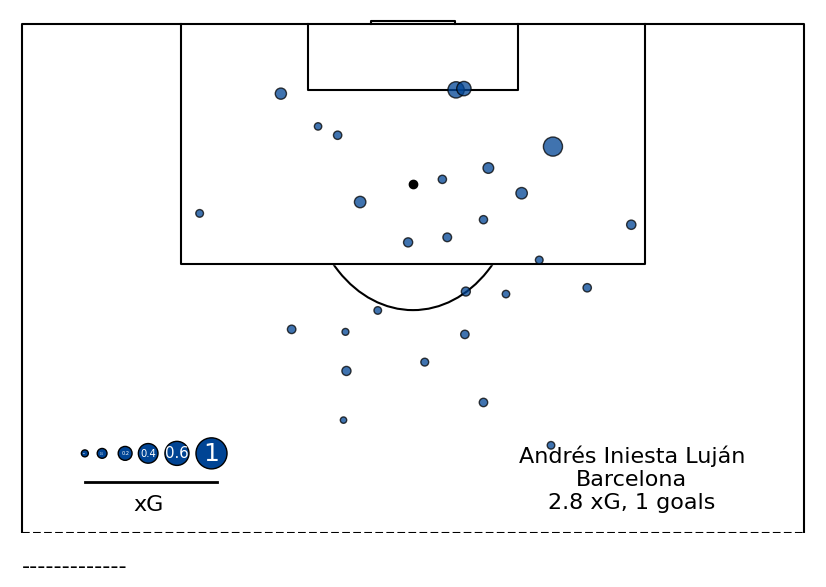

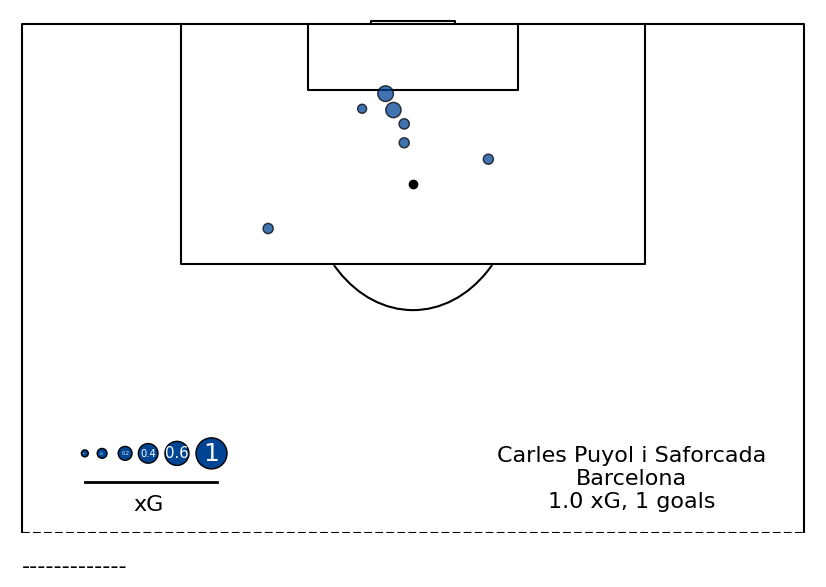

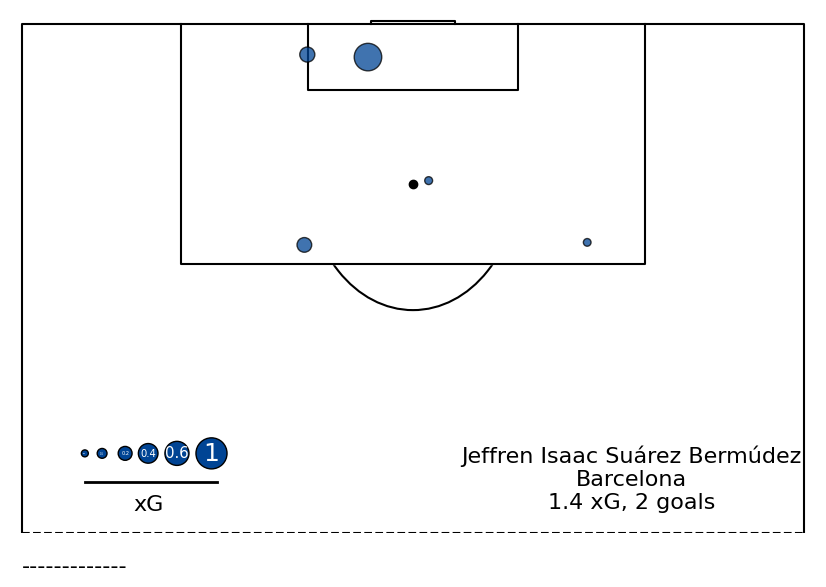

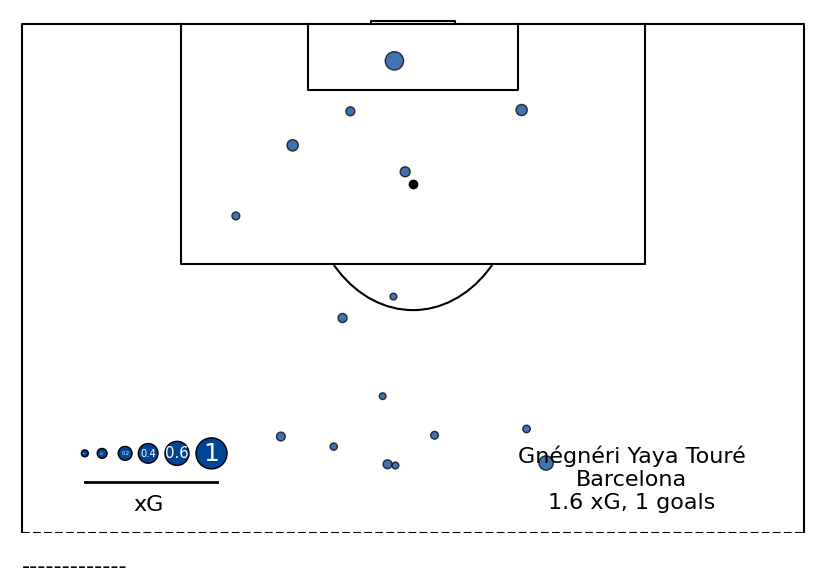

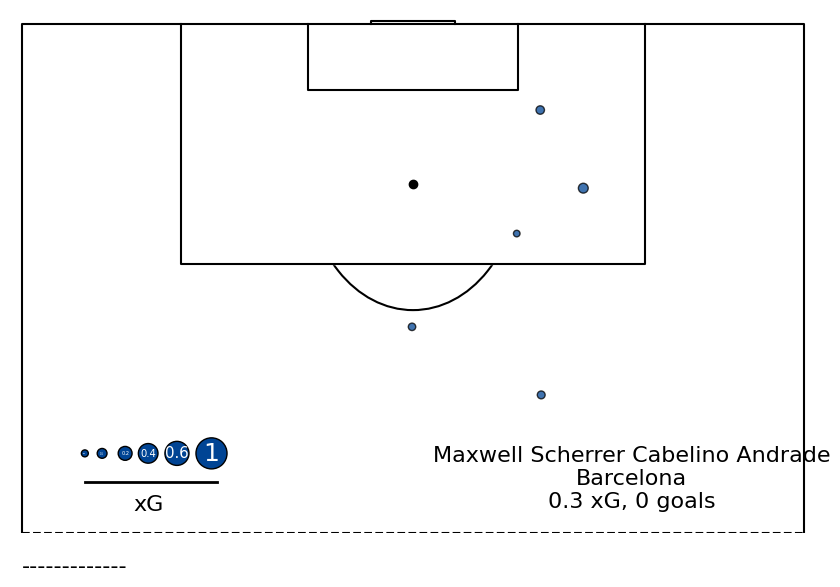

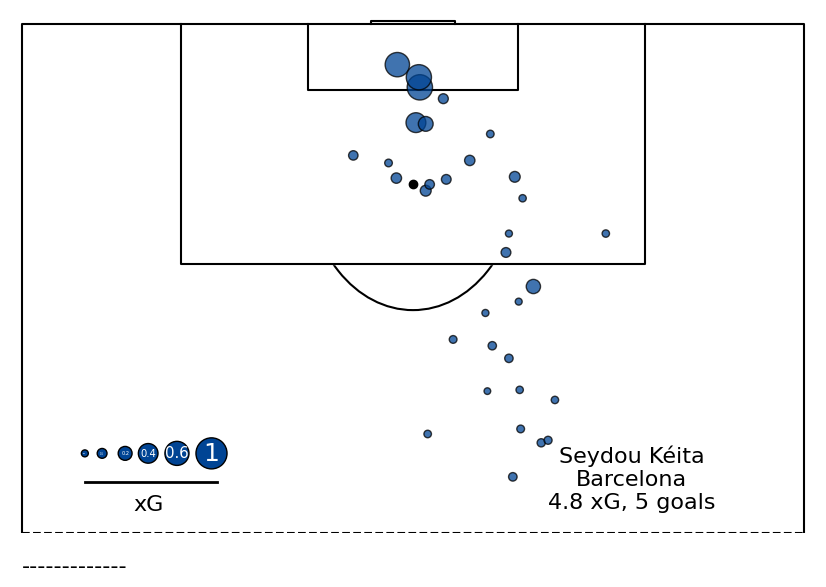

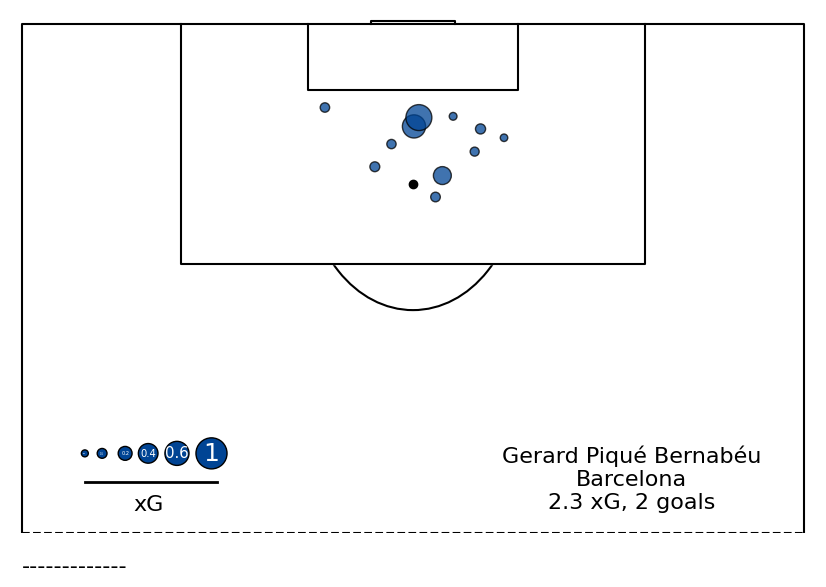

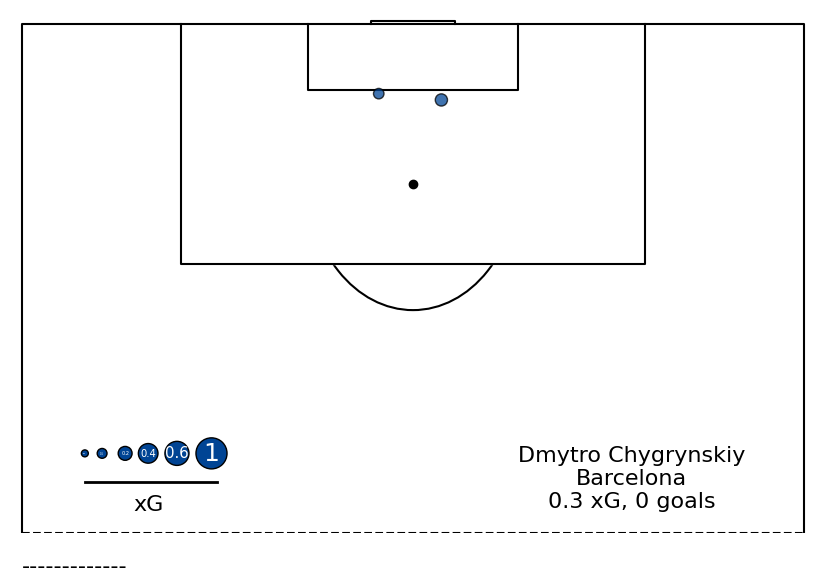

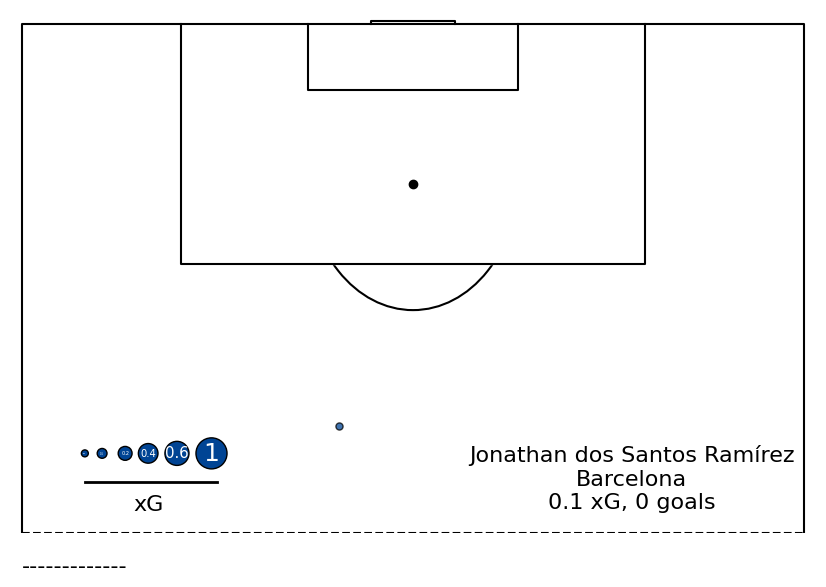

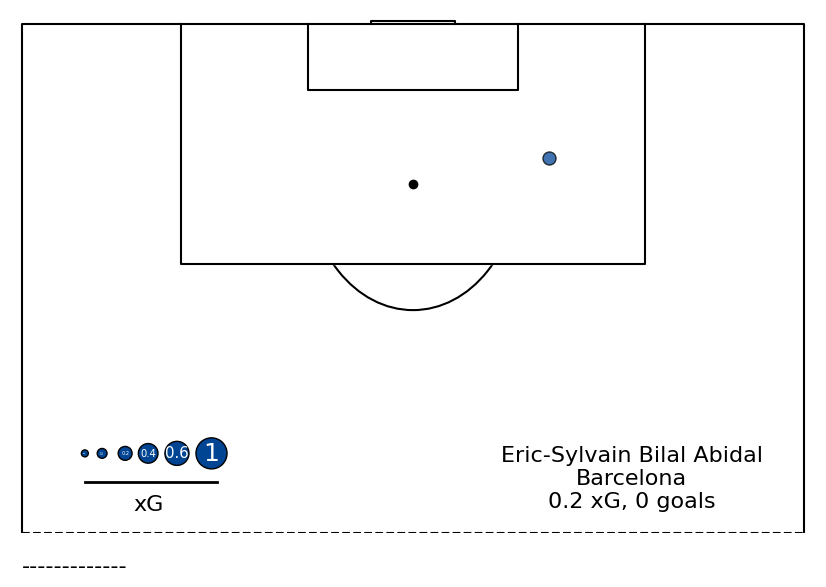

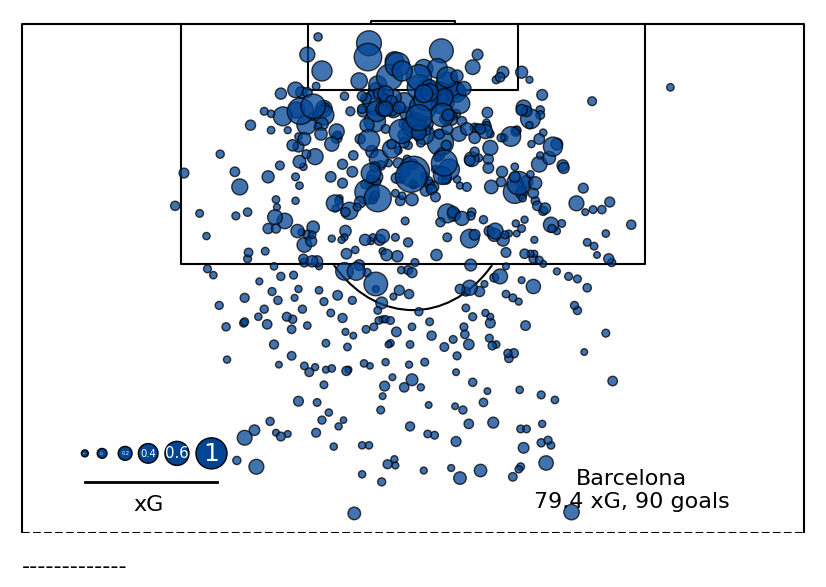

In [ ]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def xg_plot(df, team_name, player_name=None, pitch_colour='#ffffff', line_colour='#000000', marker_colour='default'):

    # Draw pitch first
    draw_pitch(pitch_colour, line_colour, orientation='vertical', view='third')

    # Filter df
    if player_name is not None:
        df = df[df['player_name'] == player_name]
        df = df[df['team_name'] == team_name]
    else:
        player_name=''
        df = df[df['team_name'] == team_name]

    markers = {'Barcelona':'#004494'}
    if marker_colour == 'default':
        marker_colour = markers.get(team_name)
    else: pass
    x_loc = df['x_loc_m']
    y_loc = [68 - i for i in df['y_loc_m']]
    xg = [500 * i for i in df['xg']]

    zo = 12

    plt.scatter(y_loc, x_loc, s=xg, c=marker_colour, edgecolors='k', zorder=zo, alpha=0.75)

    mSize = [0.05,0.10,0.2,0.4,0.6,1]
    mSizeS = [500 * i for i in mSize]
    mx = [5.5,7,9,11,13.5,16.5]
    my = [74.5,74.5,74.5,74.5,74.5,74.5]
    plt.scatter(mx, my, s=mSizeS, facecolors=marker_colour, edgecolor='k', zorder=zo)
    plt.plot([5.5,17], [72.5,72.5], color=line_colour, lw=2, zorder=zo)
    i = 0
    for i in range(len(mx)):
        plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color=pitch_colour, zorder=zo, ha='center', va='center')
    plt.text(11, 71,'xG', color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)

    xg_sum = str(round(np.sum(df['xg']), 1))
    goal_sum = str(np.sum(df['goal']))
    legend_string = player_name + '\n' + team_name + '\n' + xg_sum + ' xG, ' + goal_sum + ' goals'
    plt.text(53, 72.75, legend_string, color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)

    info_string = '-------------'
    plt.text(0, 66, info_string, color=line_colour, ha='left', va='bottom', zorder=zo, fontsize=16);
    return

players = ['Daniel Alves da Silva', 'Xavier Hernández Creus',
       'Lionel Andrés Messi Cuccittini', 'Rafael Márquez Álvarez',
       'Bojan Krkíc Pérez', 'Thierry Henry', 'Sergio Busquets i Burgos',
       'Pedro Eliezer Rodríguez Ledesma', 'Zlatan Ibrahimović',
       'Andrés Iniesta Luján', 'Carles Puyol i Saforcada',
       'Jeffren Isaac Suárez Bermúdez', 'Gnégnéri Yaya Touré',
       'Maxwell Scherrer Cabelino Andrade', 'Seydou Kéita',
       'Gerard Piqué Bernabéu', 'Dmytro Chygrynskiy',
       'Gabriel Alejandro Milito', 'Thiago Alcântara do Nascimento',
       'Jonathan dos Santos Ramírez', 'Eric-Sylvain Bilal Abidal']


#xg_plot(df=xg_df, team_name='Real Madrid', player_name='Cristiano Ronaldo dos Santos Aveiro')
for player in players:
  xg_plot(df=xg_df, team_name='Barcelona', player_name=player)
xg_plot(df=xg_df, team_name='Barcelona', player_name=None)

<ipython-input-27-293edf7515f0>:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
<ipython-input-27-293edf7515f0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_loc_m'] = 100 - df['x_loc_m']
<ipython-input-27-293edf7515f0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_loc_m'] = 68 - df['y_loc_m']


Daniel Alves da Silva
3.0 xG 3 Goals
X Location xG


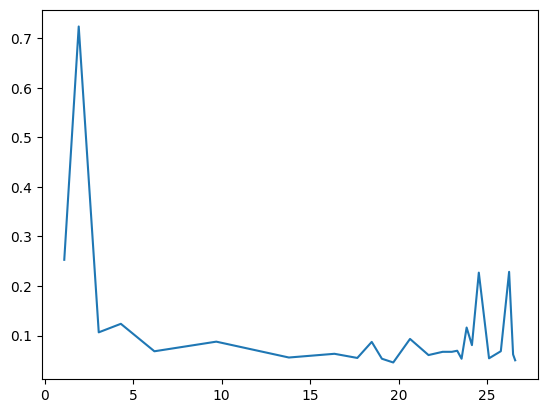

Y Location xG


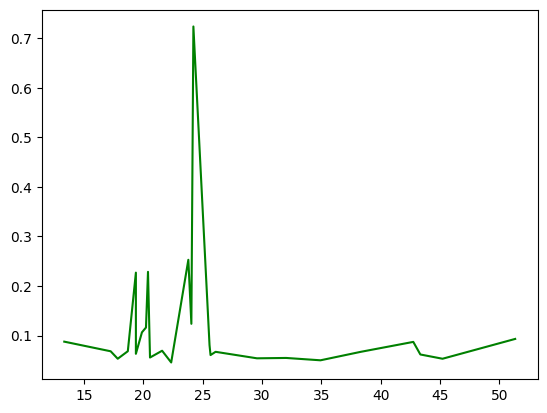

Xavier Hernández Creus
3.8 xG 3 Goals
X Location xG


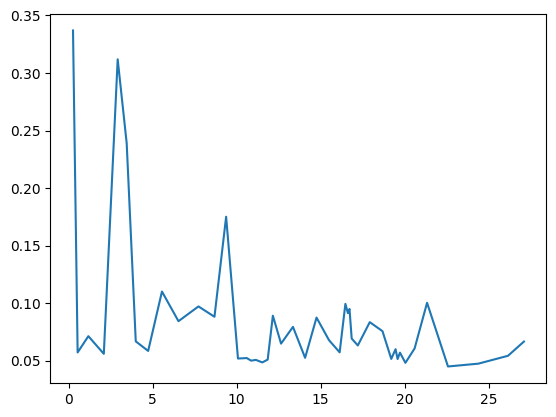

Y Location xG


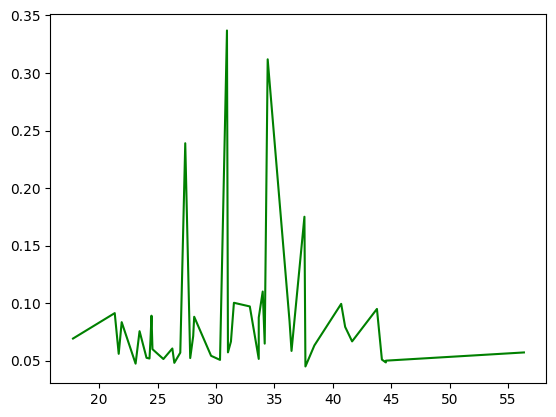

Lionel Andrés Messi Cuccittini
26.0 xG 34 Goals
X Location xG


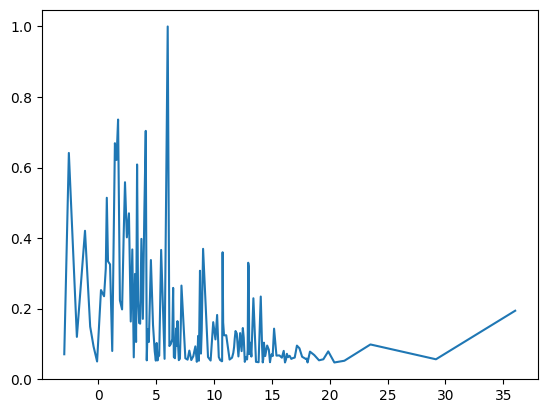

Y Location xG


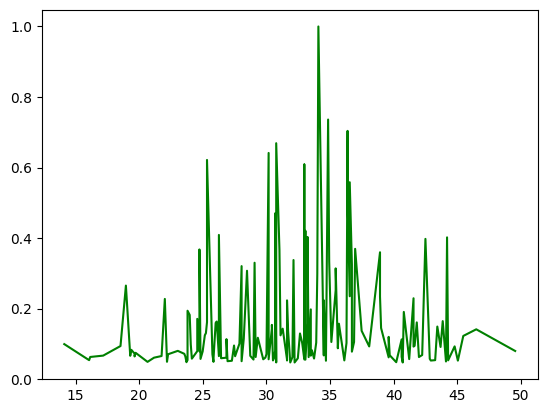

Rafael Márquez Álvarez
1.2 xG 1 Goals
X Location xG


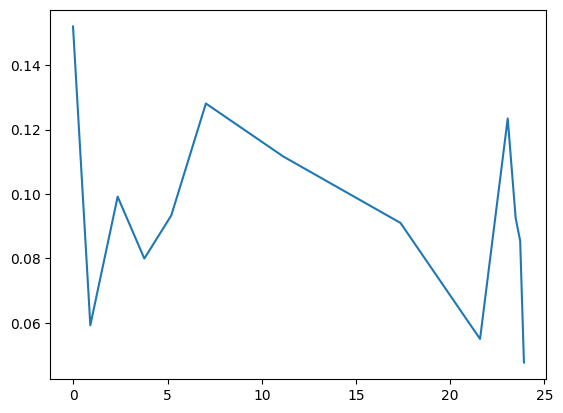

Y Location xG


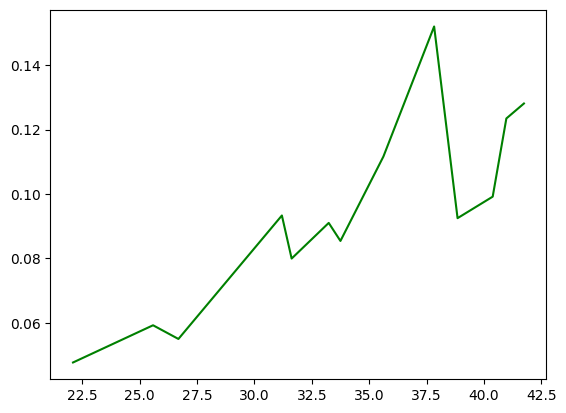

Bojan Krkíc Pérez
5.4 xG 7 Goals
X Location xG


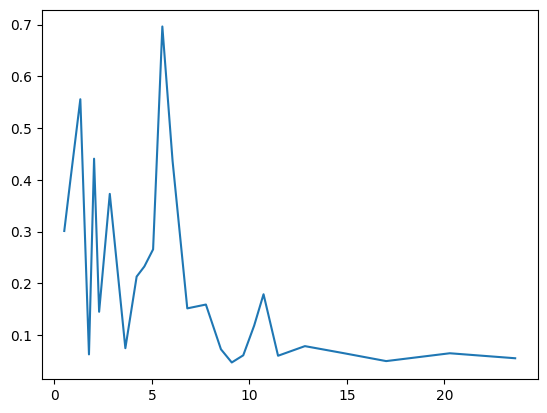

Y Location xG


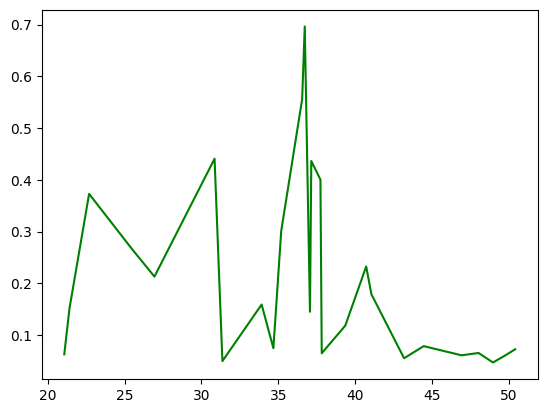

Thierry Henry
4.8 xG 4 Goals
X Location xG


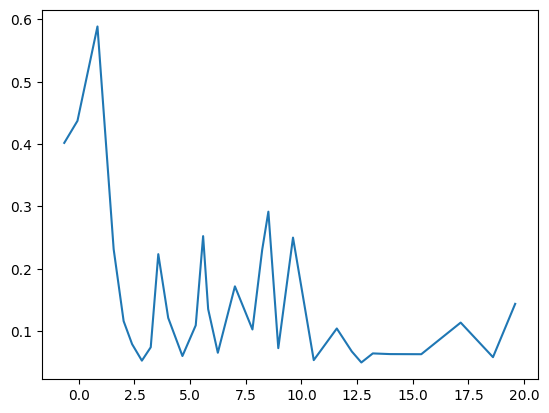

Y Location xG


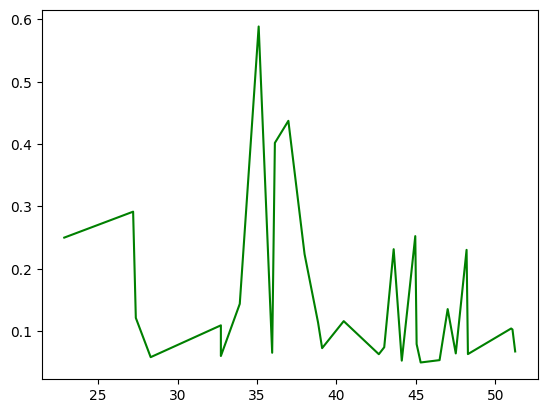

Sergio Busquets i Burgos
0.7 xG 0 Goals
X Location xG


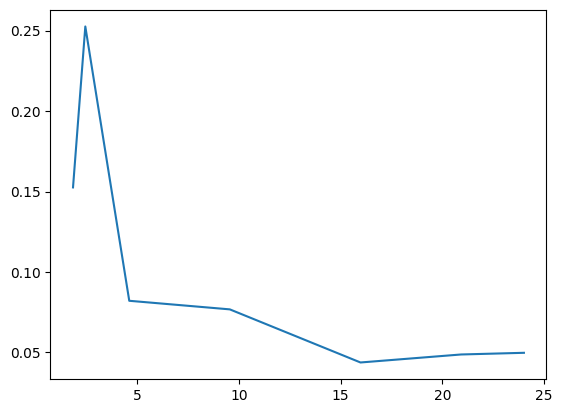

Y Location xG


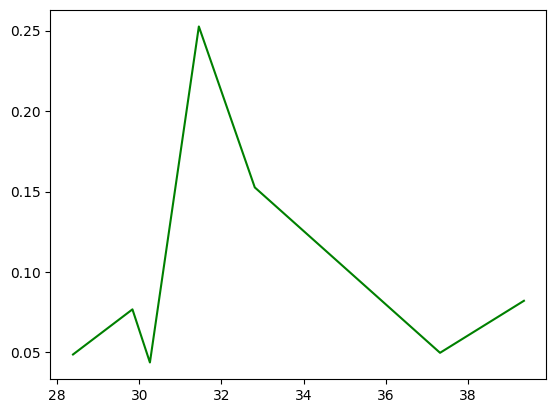

Pedro Eliezer Rodríguez Ledesma
5.7 xG 11 Goals
X Location xG


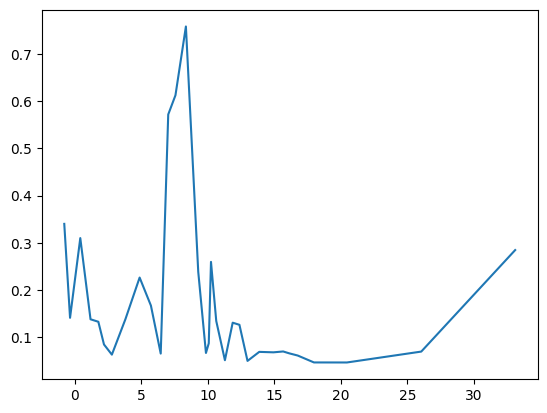

Y Location xG


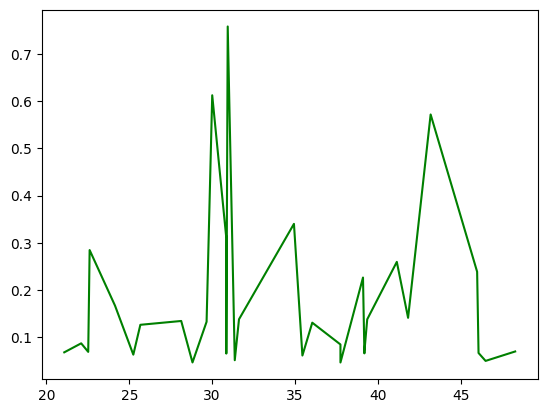

Zlatan Ibrahimović
13.5 xG 14 Goals
X Location xG


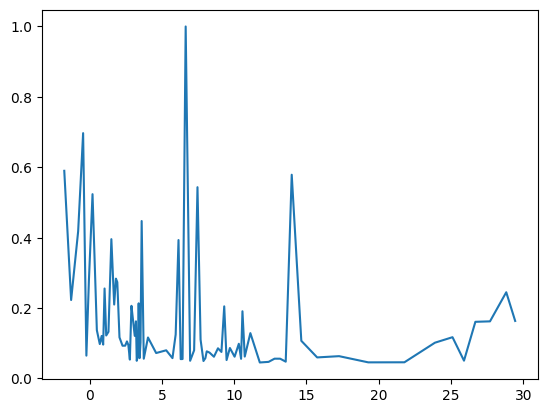

Y Location xG


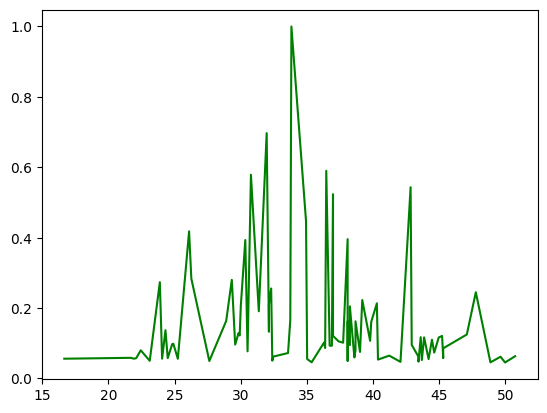

Andrés Iniesta Luján
2.8 xG 1 Goals
X Location xG


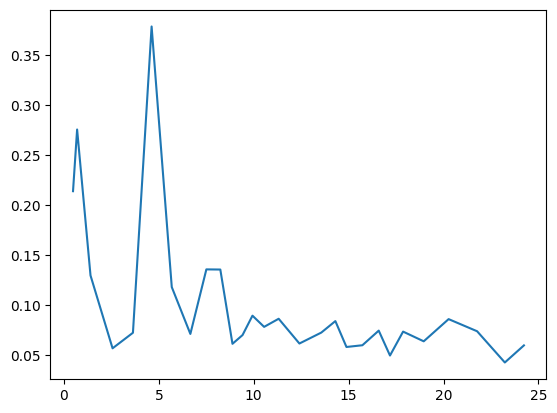

Y Location xG


Carles Puyol i Saforcada
1.0 xG 1 Goals
X Location xG


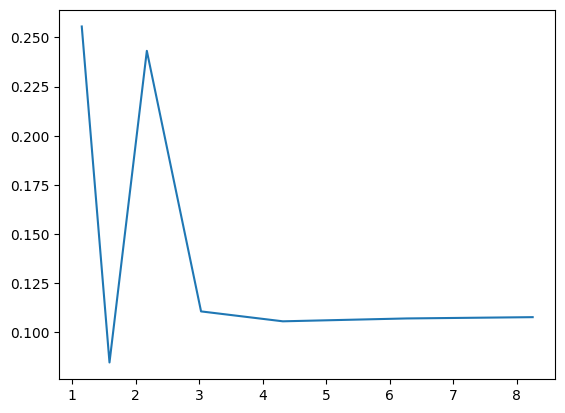

Y Location xG


Jeffren Isaac Suárez Bermúdez
1.4 xG 2 Goals
X Location xG


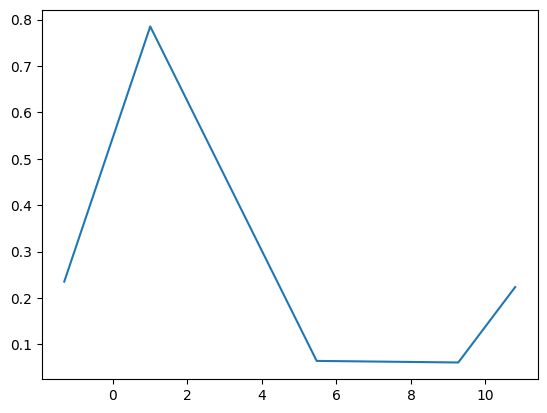

Y Location xG


Gnégnéri Yaya Touré
1.6 xG 1 Goals
X Location xG


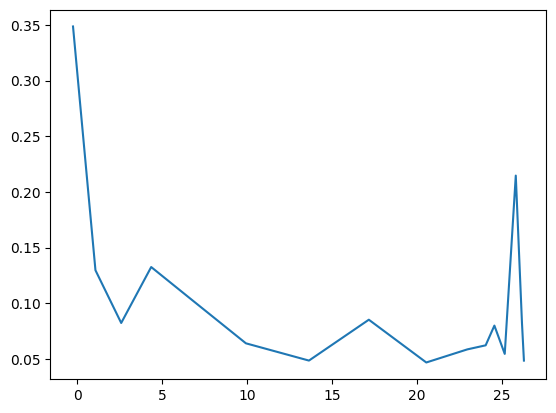

Y Location xG


Maxwell Scherrer Cabelino Andrade
0.3 xG 0 Goals
X Location xG


Y Location xG


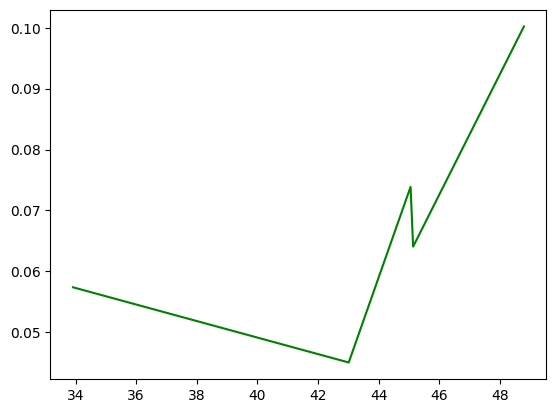

Seydou Kéita
4.8 xG 5 Goals
X Location xG


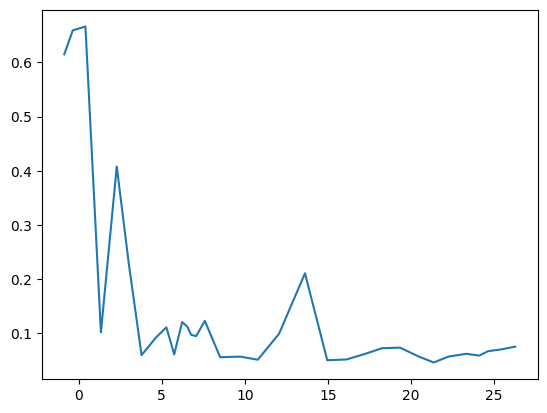

Y Location xG


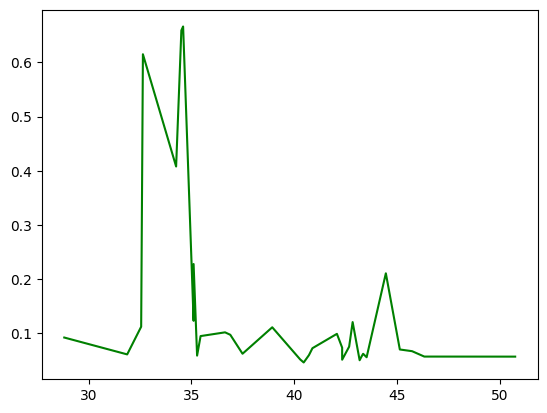

Gerard Piqué Bernabéu
2.3 xG 2 Goals
X Location xG


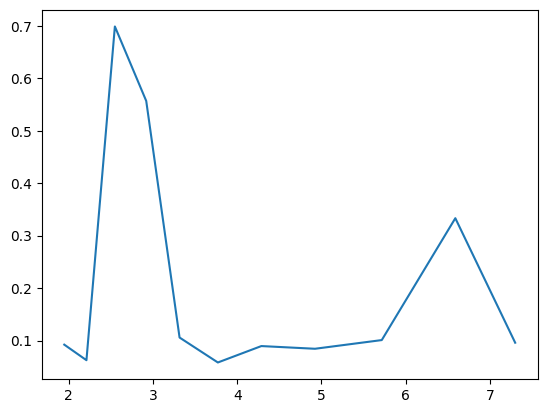

Y Location xG


Dmytro Chygrynskiy
0.3 xG 0 Goals
X Location xG


Y Location xG


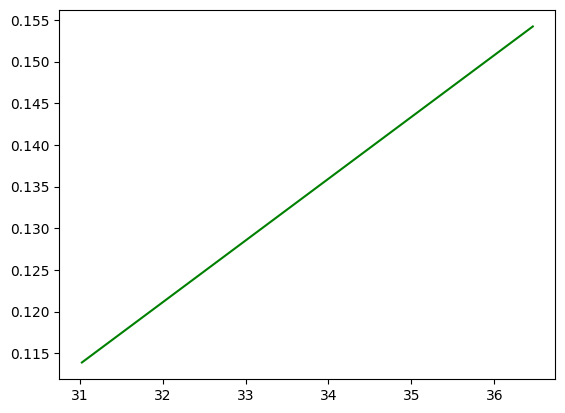

Gabriel Alejandro Milito
0.3 xG 0 Goals
X Location xG


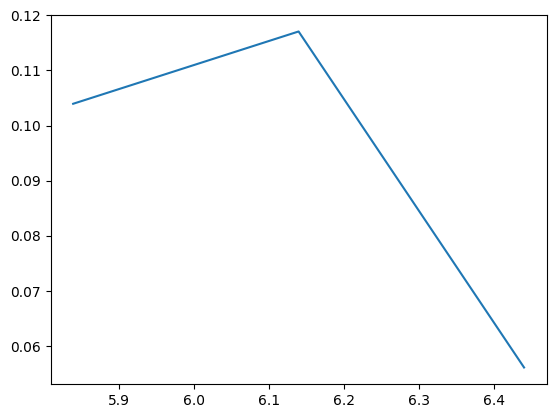

Y Location xG


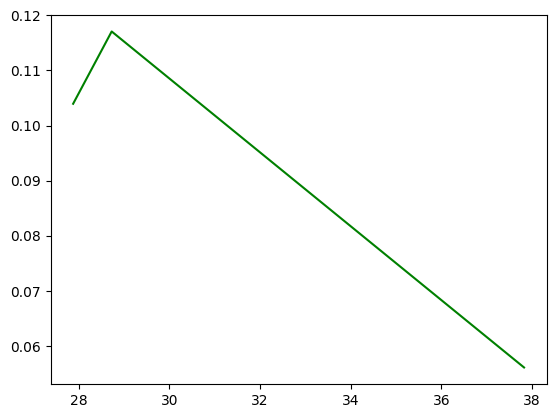

Thiago Alcântara do Nascimento
0.2 xG 1 Goals
X Location xG


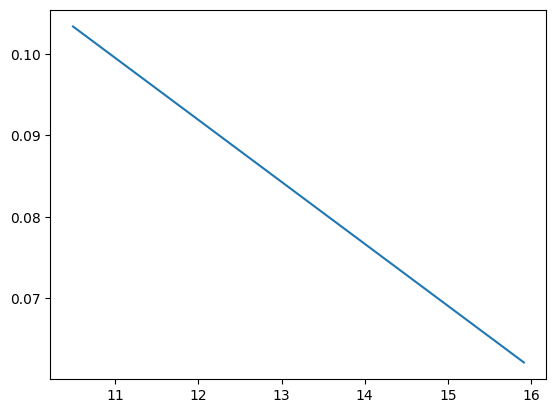

Y Location xG


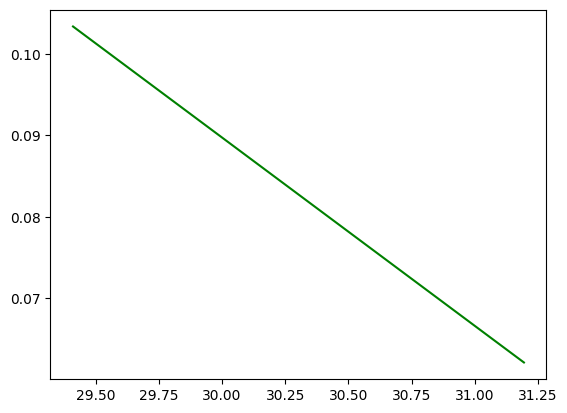

Jonathan dos Santos Ramírez
0.1 xG 0 Goals
X Location xG


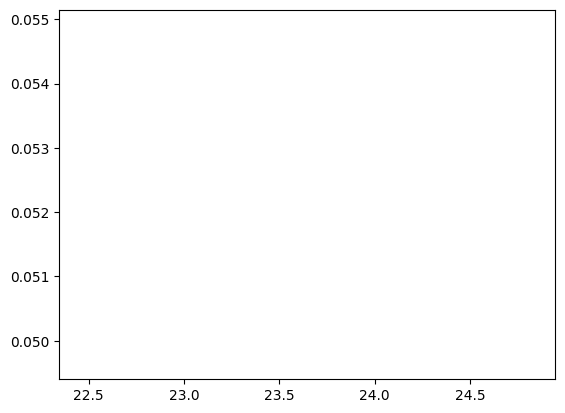

Y Location xG


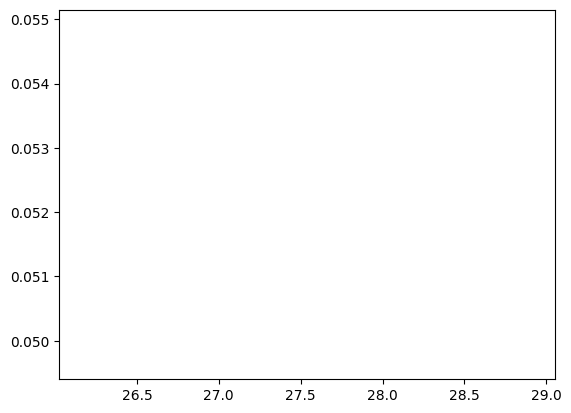

Eric-Sylvain Bilal Abidal
0.2 xG 0 Goals
X Location xG


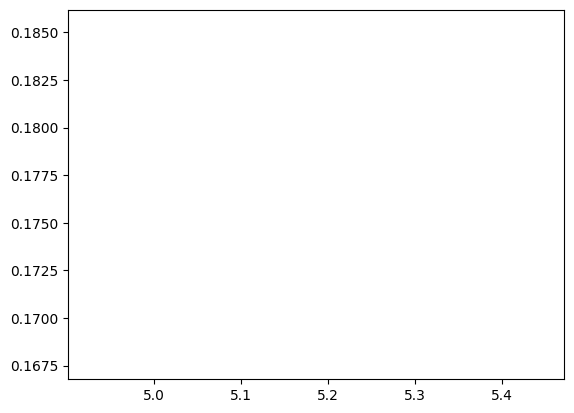

Y Location xG


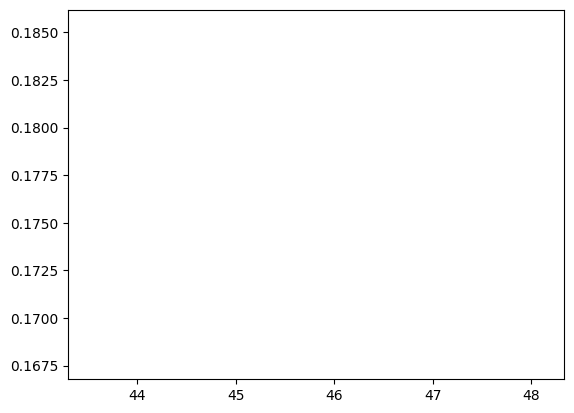

Barcelona
79.4 xG 90 Goals
X Location xG


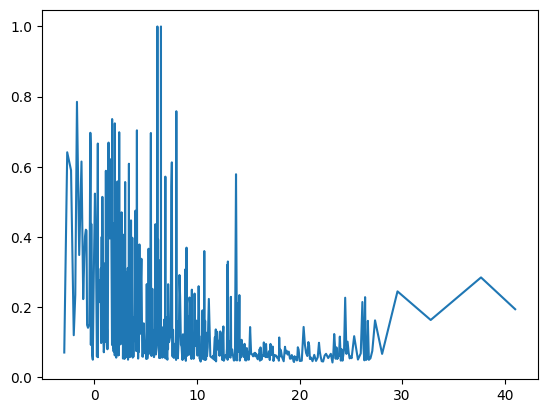

Y Location xG


In [ ]:
def print_dist_xg(df, team_name, player_name):
   label = None
   from scipy.ndimage.filters import gaussian_filter1d




   if player_name != None:
    df = df[df['player_name'] == player_name]

   else:
    df = df[df['team_name'] == team_name]

   x_loc = [i - 100 for i in df['x_loc_m']]
   df['x_loc_m'] = 100 - df['x_loc_m']
   y_loc = [68 - i for i in df['y_loc_m']]
   df['y_loc_m'] = 68 - df['y_loc_m']
   xg_sum = str(round(np.sum(df['xg']), 1))
   goal_sum = str(np.sum(df['goal']))
   if player_name != None:
    print(player_name + '\n' + str(xg_sum) + ' xG ' + str(goal_sum) + ' Goals')
   else:
    print(team_name + '\n' + str(xg_sum) + ' xG '+str(goal_sum) + ' Goals')
   df = df.sort_values(by=['x_loc_m'])
   print("X Location xG")
   ysmoothed = gaussian_filter1d(df['x_loc_m'], sigma=1)
   plt.plot( ysmoothed, df['xg'])

   plt.show()
   print("Y Location xG")
   df = df.sort_values(by=['y_loc_m'])
   plt.plot( df['y_loc_m'],df['xg'], color='green')
   #plt.xticks(df['y_loc_m'], [None for i in range(-90,90)])
   plt.show()

for player in players:
  print_dist_xg(df=xg_df, team_name='Barcelona', player_name=player)
print_dist_xg(df=xg_df, team_name='Barcelona', player_name=None)

In [ ]:
!pip install scipy